### Define Evaluate Function

In [373]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

### Load Library

In [374]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

import pycountry_convert as pc
import pycountry

import copy
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.metrics import roc_curve, auc

### Load Data

In [375]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

# Data Preprocessing

### Drop Duplicate

In [376]:
df_train.drop_duplicates(inplace = True)

### Fill Null Values

In [314]:
fillna_columns = ['id_strategic_ver', 'it_strategic_ver', 'idit_strategic_ver', 'com_reg_ver_win_rate', 'ver_win_rate_x', 'ver_win_ratio_per_bu']
for column in fillna_columns:
    df_train[column].fillna(0, inplace=True)
    df_test[column].fillna(0, inplace=True)
    
fillna_columns = ['historical_existing_cnt']
for column in fillna_columns:
    df_train[column].fillna(4, inplace=True)
    df_test[column].fillna(4, inplace=True)

### null_count

In [315]:
df_train.loc[df_train['customer_position'] == 'none', 'customer_position'] = np.nan
df_test.loc[df_test['customer_position'] == 'none', 'customer_position'] = np.nan

df_train['null_count'] = df_train.isnull().sum(axis=1)
df_test['null_count'] = df_test.isnull().sum(axis=1)

df_train['customer_position'].fillna('none', inplace=True)
df_test['customer_position'].fillna('none', inplace=True)

### customer_country

In [377]:
# 오타는 변환해야함
df_train['response_corporate'] = df_train['response_corporate'].replace('LGEBT', 'LGEPT')
df_test['response_corporate'] = df_test['response_corporate'].replace('LGEBT', 'LGEPT')

# 나라 이름 불러오기
countries = []

for country in pycountry.countries:
    countries.append(country.name)
    
# 나라 목록 확인과 대문자로 변환
cri = list(map(lambda x: x.upper(), countries))

# 결측치를 //로 대치
df_train['customer_country'][df_train['customer_country'].isna()] = '//'
df_test['customer_country'][df_test['customer_country'].isna()] = '//'

# //를 /로 대치하고 맨 뒤에있는거 그냥 부름
df_train['country'] = df_train['customer_country'].str.replace('//', '/').str.split('/').map(lambda x: x[-1]).str.strip().str.upper()
df_test['country'] = df_test['customer_country'].str.replace('//', '/').str.split('/').map(lambda x: x[-1]).str.strip().str.upper()

# 기준 나라에 있는 이름이면 이름 불러오고 아니면 ''불러오기
df_train['customer_country2'] = np.where(df_train['country'].isin(cri), df_train['country'], '')
df_test['customer_country2'] = np.where(df_test['country'].isin(cri), df_test['country'], '')

# 나라 이름 바뀐 경우 바꿔서 대입해줘야 함
before = [
    df_train['customer_country2'] == 'DEMOCRATIC REPUBLIC OF THE CONGO',
    df_train['customer_country2'] == 'U.A.E',
    df_train['customer_country2'] == 'IVORY COAST',
    df_train['customer_country2'] == "COTE D'IVOIRE",
    df_train['customer_country2'] == 'IRAN',
    df_train['customer_country2'] == 'TURKEY',
    df_train['customer_country2'] == 'SWAZILAND',
    df_train['customer_country2'] == 'UNITED REPUBLIC OF TANZANIA',
    df_train['customer_country2'] == 'SOUTH KOREA',
    df_train['customer_country2'] == 'RUSSIA',
    df_train['customer_country2'] == 'BRUNEI',
    df_train['customer_country2'] == 'TAIWAN',
    df_train['customer_country2'] == 'VIETNAM',
    df_train['customer_country2'] == 'CZECH',
    df_train['customer_country2'] == 'VENEZUELA',
    df_train['customer_country2'] == 'ST KITTS',
    df_train['customer_country2'] == 'ANTIGUA',
    df_train['customer_country2'] == 'ST MAARTEN',
    df_train['customer_country2'] == 'NETHERLANDS ANTILLES',
    df_train['customer_country2'] == 'BOLIVIA',
    df_train['customer_country2'] == 'SYRIA',
    df_train['customer_country2'] == 'MACEDONIA',
    df_train['customer_country2'] == 'PALESTINE'
]

after = [
    'CONGO',
    'UNITED ARAB EMIRATES',
    "CÔTE D'IVOIRE",
    "CÔTE D'IVOIRE",
    'IRAN, ISLAMIC REPUBLIC OF',
    'TURKEY',
    'ESWATINI',
    'TANZANIA, UNITED REPUBLIC OF',
    "KOREA, DEMOCRATIC PEOPLE'S REPUBLIC OF",
    'RUSSIA',
    'BRUNEI DARUSSALAM',
    'TAIWAN, PROVINCE OF CHINA',
    'VIETNAM',
    'CZECHIA',
    'VENEZUELA, BOLIVARIAN REPUBLIC OF',
    'SAINT KITTS AND NEVIS',
    'ANTIGUA AND BARBUDA',
    'SINT MAARTEN (DUTCH PART)',
    'NETHERLANDS',
    'BOLIVIA, PLURINATIONAL STATE OF',
    'SYRIAN ARAB REPUBLIC',
    'NORTH MACEDONIA',
    'PALESTINE, STATE OF'
]

df_train['customer_country3'] = np.select(before, after, default=df_train['customer_country2'])

# 나라 이름 바뀐 경우 바꿔서 대입해줘야 함
before = [
    df_test['customer_country2'] == 'DEMOCRATIC REPUBLIC OF THE CONGO',
    df_test['customer_country2'] == 'U.A.E',
    df_test['customer_country2'] == 'IVORY COAST',
    df_test['customer_country2'] == "COTE D'IVOIRE",
    df_test['customer_country2'] == 'IRAN',
    df_test['customer_country2'] == 'TURKEY',
    df_test['customer_country2'] == 'SWAZILAND',
    df_test['customer_country2'] == 'UNITED REPUBLIC OF TANZANIA',
    df_test['customer_country2'] == 'SOUTH KOREA',
    df_test['customer_country2'] == 'RUSSIA',
    df_test['customer_country2'] == 'BRUNEI',
    df_test['customer_country2'] == 'TAIWAN',
    df_test['customer_country2'] == 'VIETNAM',
    df_test['customer_country2'] == 'CZECH',
    df_test['customer_country2'] == 'VENEZUELA',
    df_test['customer_country2'] == 'ST KITTS',
    df_test['customer_country2'] == 'ANTIGUA',
    df_test['customer_country2'] == 'ST MAARTEN',
    df_test['customer_country2'] == 'NETHERLANDS ANTILLES',
    df_test['customer_country2'] == 'BOLIVIA',
    df_test['customer_country2'] == 'SYRIA',
    df_test['customer_country2'] == 'MACEDONIA',
    df_test['customer_country2'] == 'PALESTINE'
]

after = [
    'CONGO',
    'UNITED ARAB EMIRATES',
    "CÔTE D'IVOIRE",
    "CÔTE D'IVOIRE",
    'IRAN, ISLAMIC REPUBLIC OF',
    'TÜRKIYE',
    'ESWATINI',
    'TANZANIA, UNITED REPUBLIC OF',
    "KOREA, DEMOCRATIC PEOPLE'S REPUBLIC OF",
    'RUSSIA',
    'BRUNEI DARUSSALAM',
    'TAIWAN, PROVINCE OF CHINA',
    'VIETNAM',
    'CZECHIA',
    'VENEZUELA, BOLIVARIAN REPUBLIC OF',
    'SAINT KITTS AND NEVIS',
    'ANTIGUA AND BARBUDA',
    'SINT MAARTEN (DUTCH PART)',
    'NETHERLANDS',
    'BOLIVIA, PLURINATIONAL STATE OF',
    'SYRIAN ARAB REPUBLIC',
    'NORTH MACEDONIA',
    'PALESTINE, STATE OF'
]

df_test['customer_country3'] = np.select(before, after, default=df_test['customer_country2'])

# 지사별 나라의 딕셔너리 구성
country_dict = {"LGERA": "Russia",
"LGEUR": "Ukraine",
"LGEAP": "Australia",
"LGECH": "China",
"LGEHK": "Hong Kong",
"LGEIL": "India",
"LGEIN": "Indonesia",
"LGEJP": "Japan",
"LGEKR": "Korea",
"LGEML": "Malaysia",
"LGEPH": "Philippines",
"LGESL": "Singapore",
"LGETT": "Taiwan, Province of China",
"LGETH": "Thailand",
"LGEAR": "Argentina",
"LGECZ": "Czechia",
"LGEFS": "France",
"LGEDG": "Germany",
"LGEAG": "Austria",
"LGEHS": "Greece",
"LGEMK": "Hungary",
"LGEIS": "Italy",
"LGEBN": "Netherlands",
"LGEPL": "Poland",
"LGEPT": "Portugal",
"LGERO": "Romania",
"LGEES": "Spain",
"LGESW": "Sweden",
"LGEUK": "United Kingdom",
"LGEAS": "Algeria",
"LGEEG": "Egypt",
"LGELF": "Jordan",
"LGEMC": "Morocco",
"LGESA": "The Republic of South Africa",
"LGEGF": "United Arab Emirates",
"LGEAF": "United Arab Emirates",
"LGETK": "Turkiye",
"LGECI": "Canada",
"LGEMX": "Mexico",
"LGEMS": "Mexico",
"LGEUS": "United States",
"LGECL": "Chile",
"LGECB": "Colombia",
"LGEPS": "Panama",
"LGEPR": "Peru",
"LGESJ": "Saudi Arabia",
"LGESP": "Brazil",
"LGEEF": "Kenya",
"LGEYK": "Palestine, State of",
"LGEEB": "en_EU", 
"LGEVH": "Viet Nam",
"LGELA": "Latvia",
"LGEIR": "Iran, Islamic Republic of",
"LGEBT": "Portugal"
               }

In [378]:
# 나라 이름 대입
ccc = pd.DataFrame(countries, cri).reset_index()
ccc.columns = ['upper', 'countries']

# 대문자로 전부 만든거 다시 되돌리기
train2 = pd.merge(df_train, ccc, how='left', left_on='customer_country3', right_on='upper')
df_train = train2
test2 = pd.merge(df_test, ccc, how='left', left_on='customer_country3', right_on='upper')
df_test = test2

# 지사에 맞게 값을 넣어주기
df_train['customer_country4'] = np.where(df_train['countries'].isna(),
                                         df_train['response_corporate'].apply(lambda x: country_dict[x]),
                                         df_train['countries'])
df_test['customer_country4'] = np.where(df_test['countries'].isna(),
                                        df_test['response_corporate'].apply(lambda x: country_dict[x]),
                                        df_test['countries'])

# 나라 대입해서 바꿔놓기
df_train['customer_country'] = df_train['customer_country4']
df_test['customer_country'] = df_test['customer_country4']

# 생성한 변수 전부 삭제
df_train.drop(['country', 'customer_country2', 'customer_country3', 'upper', 'countries',
           'customer_country4', 'customer_country.1'], axis = 1, inplace = True)
df_test.drop(['country', 'customer_country2', 'customer_country3', 'upper', 'countries',
          'customer_country4', 'customer_country.1'], axis = 1, inplace = True)

# 반영이 안되는 값들 반영 되는 값으로 변경
df_train['customer_country'][df_train['customer_country'] == 'Turkiye'] = 'Türkiye'
df_train['customer_country'][df_train['customer_country'] == 'The Republic of South Africa'] = 'South Africa'
df_train['customer_country'][df_train['customer_country'] == 'Korea'] = "Korea, Democratic People's Republic of"

### continent

In [379]:
# 함수 만들기
def country_to_continent(country_name):
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name

# 있으면 대륙이름 없으면 나라이름 대입하기
cont = []
for i in df_train['customer_country']:
    try:
        cont.append(country_to_continent(i))
    except:
        cont.append(i)

# test에서도 똑같이
cont2 = []
for i in df_test['customer_country']:
    try:
        cont2.append(country_to_continent(i))
    except:
        cont2.append(i)

# 칼럼 만들기
df_train['continent'] = cont
df_test['continent'] = cont2

# EU는 유럽
df_train['continent'][df_train['continent'] == 'en_EU'] = 'Europe'
df_test['continent'][df_test['continent'] == 'en_EU'] = 'Europe'

### response_corporate

In [319]:
# Frequency가 10 이하인 것들은 묶어서 Etc로 묶어버리자.
frequency = df_train['response_corporate'].value_counts()
low_frequency_categories = frequency[frequency <= 10].index
df_train['response_corporate'] = df_train['response_corporate'].apply(lambda x: 'Too_Low' if x in low_frequency_categories else x)
df_test['response_corporate'] = df_test['response_corporate'].apply(lambda x: 'Too_Low_in_train' if x in low_frequency_categories else x)

### customer_type

In [320]:
# 동일화 할건 동일화 하자.
# Specifier / Influencer
change_list = ['Specifier / Influencer', 'Specifier/ Influencer', 'Installer/Contractor', 'Architect/Consultant'
, 'Interior Designer', 'Technician', 'Technical Assistant', 'Installer', 'Consultant']
for item in change_list:
    df_train.loc[df_train['customer_type'] == item, 'customer_type'] = 'Specifier/ Influencer'
    df_test.loc[df_test['customer_type'] == item, 'customer_type'] =  'Specifier/ Influencer'

# Others
change_list = ['Etc.', 'Others', 'Other']
for item in change_list:
    df_train.loc[df_train['customer_type'] == item, 'customer_type'] = 'Others'
    df_test.loc[df_test['customer_type'] == item, 'customer_type'] =  'Others'

# Home Owner
change_list = ['Homeowner', 'Home Owner']
for item in change_list:
    df_train.loc[df_train['customer_type'] == item, 'customer_type'] = 'Homeowner'

# End-User
change_list = ['End-Customer', 'End Customer', 'End-user', 'Corporate', 'Developer']
for item in change_list:
    df_train.loc[df_train['customer_type'] == item, 'customer_type'] = 'End-Customer'
    df_test.loc[df_test['customer_type'] == item, 'customer_type'] =  'End-Customer'

# Channel Partner
change_list = ['Channel Partner', 'Dealer/Distributor', 'Reseller', 'Distributor', 'System Integrator']
for item in change_list:
    df_train.loc[df_train['customer_type'] == item, 'customer_type'] = 'channel partner'
    df_test.loc[df_test['customer_type'] == item, 'customer_type'] =  'channel partner'

# 그 이후에 Frequency가 10 이하인 것들은 묶어서 Etc로 묶어버리자.
frequency = df_train['customer_type'].value_counts()
low_frequency_categories = frequency[frequency <= 10].index
df_train['customer_type'] = df_train['customer_type'].apply(lambda x: 'Too_Low' if x in low_frequency_categories else x)
df_test['customer_type'] = df_test['customer_type'].apply(lambda x: 'Too_Low' if x in low_frequency_categories else x)

### expected_timeline

In [321]:
### 동일화 할 것은 동일화를 하자.
# 3개월 이내
change_list = ['less than 3 months',
'3 months',
'less_than_3_months',
'less than 3 months ,meeting with the customer for the more details and tentative boq will ne 32 and 43',
'less than 3 months. customer not answered . to call back',
'less than 3 months- outdoor led requiment',
'duplicate lead - il220100042906. less than 3 months']
for item in change_list:
    df_train.loc[df_train['expected_timeline'] == item, 'expected_timeline'] = 'less than 3 months'
    df_test.loc[df_test['expected_timeline'] == item, 'expected_timeline'] =  'less than 3 months'

# 6개월 이내
change_list = ['less than 6 months', 'less then 6 months']
for item in change_list:
    df_train.loc[df_train['expected_timeline'] == item, 'expected_timeline'] = 'less than 6 months'
    df_test.loc[df_test['expected_timeline'] == item, 'expected_timeline'] =  'less than 6 months'

# 3~6개월 이내
change_list = ['3 months ~ 6 months', '3_months_~6_months', '3_months_~_6_months']
for item in change_list:
    df_train.loc[df_train['expected_timeline'] == item, 'expected_timeline'] = '3 months ~ 6 months'
    df_test.loc[df_test['expected_timeline'] == item, 'expected_timeline'] =  '3 months ~ 6 months'

change_list = ['6 months ~ 9 months', '6_months*~_9_months', '6_months~_9_months', '6_months_~_9_months']
for item in change_list:
    df_train.loc[df_train['expected_timeline'] == item, 'expected_timeline'] = '6 months ~ 9 months'
    df_test.loc[df_test['expected_timeline'] == item, 'expected_timeline'] =  '6 months ~ 9 months'

change_list = ['9 months ~ 1 year', '9 months - 1 year', '9_months*~*1_year', '9_months~1_year', '9_months_~_1_year']
for item in change_list:
    df_train.loc[df_train['expected_timeline'] == item, 'expected_timeline'] = '9 months ~ 1 year'
    df_test.loc[df_test['expected_timeline'] == item, 'expected_timeline'] =  '9 months ~ 1 year'

change_list = ['more than a year', 'more_than_a_year']
for item in change_list:
    df_train.loc[df_train['expected_timeline'] == item, 'expected_timeline'] = 'more than a year'
    df_test.loc[df_test['expected_timeline'] == item, 'expected_timeline'] =  'more than a year'

change_list = [ 'being followed up', 'being followed up.']
for item in change_list:
    df_train.loc[df_train['expected_timeline'] == item, 'expected_timeline'] = 'being followed up.'
    df_test.loc[df_test['expected_timeline'] == item, 'expected_timeline'] =  'being followed up.'

### 그 이후에 Frequency가 10 이하인 것들은 묶어서 Etc로 묶어버리자.
frequency = df_train['expected_timeline'].value_counts()
low_frequency_categories = frequency[frequency < 10].index
df_train['expected_timeline'] = df_train['expected_timeline'].apply(lambda x: 'Too_Low' if x in low_frequency_categories else x)
df_test['expected_timeline'] = df_test['expected_timeline'].apply(lambda x: 'Too_Low' if x in low_frequency_categories else x)

### inquiry_type

In [322]:
### 동일화 시킬건 동일화 하자
# Quotation or purchase consultation
change_list = ['Quotation or purchase consultation', 'quotation_or_purchase_consultation', 'Quotation or Purchase Consultation', 
               'Quotation or Purchase consultation', 'Purchase or Quotation', 'quotation_', 'Request for quotation or purchase', 'Purchase']
for item in change_list:
    df_train.loc[df_train['inquiry_type'] == item, 'inquiry_type'] = 'Quotation or Purchase Consultation'
    df_test.loc[df_test['inquiry_type'] == item, 'inquiry_type'] = 'Quotation or Purchase Consultation'

# Usage or Technical Consultation
change_list = ['Usage or technical consultation', 'Technical Support', 'usage or technical consultation', 'usage_or_technical_consultation', 'Usage or Technical Consultation', 'technical_consultation', 'Request for technical consulting', 'Technical Consultation', 'technical']
for item in change_list:
    df_train.loc[df_train['inquiry_type'] == item, 'inquiry_type'] = 'Usage or Technical Consultation'
    df_test.loc[df_test['inquiry_type'] == item, 'inquiry_type'] = 'Usage or Technical Consultation'

# Others
change_list = ['others', 'Others', 'other_' , 'Etc.' , 'Other', 'ETC.', 'other']
for item in change_list:
    df_train.loc[df_train['inquiry_type'] == item, 'inquiry_type'] =  'Others'
    df_test.loc[df_test['inquiry_type'] == item, 'inquiry_type'] =  'Others'

# Sales Inquiry
change_list = ['Sales inquiry', 'sales', 'Sales inquiry']
for item in change_list:
    df_train.loc[df_train['inquiry_type'] == item, 'inquiry_type'] = 'Sales inquiry'
    df_test.loc[df_test['inquiry_type'] == item, 'inquiry_type'] = 'Sales inquiry'

### 그 이후에 Frequency가 10 이하인 것들은 묶어서 Etc로 묶어버리자.
frequency = df_train['inquiry_type'].value_counts()
low_frequency_categories = frequency[frequency <= 10].index
df_train['inquiry_type'] = df_train['inquiry_type'].apply(lambda x: 'Others' if x in low_frequency_categories else x)
df_test['inquiry_type'] = df_test['inquiry_type'].apply(lambda x: 'Others' if x in low_frequency_categories else x)

### product_category

In [323]:
# 'product_category' 열의 각 값을 /로 분할합니다.
df_train['product_category'] = df_train['product_category'].str.split(',')

# explode 함수를 사용하여 각 분할된 값을 별도의 행으로 만듭니다.
df_train = df_train.explode('product_category')

# 'product_category' 열의 각 값을 /로 분할합니다.
df_train['product_category'] = df_train['product_category'].str.split('+')

# explode 함수를 사용하여 각 분할된 값을 별도의 행으로 만듭니다.
df_train = df_train.explode('product_category')

def preprocess_cate(cate):
    if isinstance(cate, str):        
        multisplit = ['multi-split','multi-split (plusieurs pièces)',
                      'klimatyzacja multi-split','multi split','פיצול מרובה',
                     'multi v5 vrf', 'multi v','vrf - multi v s', 'multi v 5 air',
                      'multi v water 5']

        if cate in multisplit:
            return 'multi-split'
        
        singlesplit = ['single-split','single split','split tunggal']

        if cate in singlesplit:
            return 'single-split'
        
        chiller = ['chiller', 'chiller/enfriadoras',
                  'điều hòa trung tâm chiller','chill',
                   'مبرد (تشيلر)','تكييف وتبريد',
                   'systèmes de débit à réfrigérant variable (drv)',
                   'soğutucu','pendingin',
                  ]
        
        if cate in chiller:
            return 'chiller'
        
        inverter = ['teto ou cassete inverter','multi inverter','rac single cac',
                   'single cac', 'rac/cac','rac','cac','sac']
        
        if cate in inverter:
            return 'inverter'
        
        vrf = ['vrf','all lg vrf systems',
              'نظام التدفق المتغيرvrf','kimatyzacja vrf',
              'điều hòa trung tâm vrf',
              'เครื่องปรับอากาศเผื่อที่อยู่อาศัย','מזגנים למקום מגורים',
               'điều hòa gia dụng','تكييفات','',
               'điều hòa cục bộ','ac rumah','aquecimento',
               'aire acondicionado residencial',
               'điều hòa trung tâm multi','climatiseur résidentiel',
               'residential air conditioner','system ac','ar condicionado residencial',
               'system air conditioner',
              ]
        
        if cate in vrf:

            return 'vrf'
        
        heating = ['heating','חימום','حلول التدفئة','calefacción',
                  'ogrzewanie (pompy ciepła)','isıtma',]
        
        if cate in heating:
            return 'heating'
        
        onequick = ['one:quick series','lg one:quick']
        
        if cate in onequick:
            return 'one:quick series'
        
        videowall = ['video wall signage','video wall', ' video wall',
                     'videowall signage' ,'videowall_rmk', 'video wall ',
                    'videwall',]
        
        if cate in videowall:
            return 'video wall'
        
        audiovideo = ['audio/video','audio','audio/']
        
        if cate in audiovideo:
            return'audio/video'
        
        robots = ['robot','robots']
        
        if cate in robots:
            return'robots'
        
        oled = ['oled signage','oled 顯示屏','transparent oled']
        
        if cate in oled:
            return'oled signage'
        
        commercialtv = ['commercial tv','comercial tv','digital signage or commercial tvs',
                       'digital signage','ultra stretch series',]
        
        if cate in commercialtv:
            return 'digital signage or commercial tvs'
        
        procentric = ['pro:centric','procentric']
        
        if cate in procentric:
            return 'pro:centric'
        
        onequick = ['one:quick series', 'lg one:quick series','onequick series']
        
        if cate in onequick:
            return 'one:quick series'

        medicaldisplay = ['medical display', 'medical displays','radiology displays']
        
        if cate in medicaldisplay:
            return 'medical displays'
        
        medicalmonitors = ['medical monitors','medical monitor']
        
        if cate in medicalmonitors:
            return 'medical displays'
        
        surgicalmonitor = ['surgical monitor','medical- surgical']
        
        if cate in surgicalmonitor:
            return 'surgical'
        
        monitorsnpc = ['monitor & pc',]        
        
        if cate in monitorsnpc:
            return 'monitor & pc'
        
        highbrightness = ['high brightness signage', 'high brightness']
        
        if cate in highbrightness:
            return 'high brightness signage'
        
        signagecaresolution = ['signage care solution','signage care solutions']
        
        if cate in signagecaresolution:
            return 'signage care solutions'
        
        ur640s = ['ur640','ur640s']
                
        if cate in ur640s:
            return 'ur640s'
        
        hoteltv = ['酒店電視','hotel tv']
        
        if cate in hoteltv:
            return 'hotel tv'
        
        interactivetv = ['互動式顯示屏','interactive digital board']
        
        if cate in interactivetv:
            return 'interactive digital board'
        
        standarddisplay = ['標準顯示屏']
        
        if cate in standarddisplay:
            return 'standard display'
        
        onequickseries =['one quick:flex','one:quick flex','one:quick series',
                        'one quick works','one:quick']
        
        if cate in onequickseries:
            return 'one:quick series'

        leddisplay = ['led 顯示屏','leadallin','ledallinone','allinone_rmk',
                     ' aio','aio','aio | one quick','ledallinone','led','led signage']
        
        if cate in leddisplay:
            return 'led display'
        
        monitortv = ['monior/monitor tv','monitor','monitor signage']
        
        if cate in monitortv:
            return 'monior/monitor tv'
        
        x = ['parts','lsca039','a definir','','inne','id','آخر',
             'ฯลฯ','ahu','tr3','98uh5e','49vl5g-m.awzm','43us660h0sd.awz',
             '43uq751c0sb.bwz','laec015-gn.awz','49vl5g-m','49vl5f',
             '55vm5j-h','corpuh5f-','86uh5f','55tc3d','43us660h (na)',
             'hoteleria_us670h','gsca046' ,'gscd100','55svh7f-a',
             '55us660h0sd.bwz', '50us660h0sd.bwz','32lq621cbsb.awz', 
             '43uh5f-h.awzm', '55uq801c0sb.bwz', '43uq751c0sf.bwz',
             'gscd046','50uq801c0sb.bwz','bu50nst','55vm5e-a','28mq780',
             '醫院電視','軟體','vb.','hospitality','error',
             'essential series','laec015','43us660h0sd.awz',
             '50uq801c0sb.bwz','43uq751c0sb.bwz', 'laec015-gn.awz',
             'high inch 86 / 98 or 110','meeting & screen sharedirect view leddirect view led',
             'not specified','110 ','tv 60"', 'tv 43 pol' ,'43 pol',
             'tv 55"','smart tv','ctv','32 pol','laec15','pantalla led outdoor',
             'on or several reversible ac','49uh / 49xf','scroll compressor',
             'corpouh5f','unitario','retaildigital','led aio 136','built',
             'single package','led 70m2','高亮度顯示屏','特別顯示屏','monitorindustrial_rmk',
             'lg magnit', 'uh','32 / 43 pol','styler','htv','pro centric hotel',
             'washing mach','lg led bloc','taa lcd lfd displays','information display',
             'window facing display','lg customer care program','tv signage',
             'collaboration displays','computer monitors', 'lg salang air solution for dream homes',
             'lg home bliss air solution','lg home bliss air solution','lg paradise air solution'
            ]

        if cate in x:

            return 'x'
        
        other = ['etc.','outros','others','other','autre','khác','lainnya',
                 'otros','אחר',
                ]
        
        if cate in other:
            return 'Other'
        
    return cate


df_train['product_category'] = df_train['product_category'].apply(preprocess_cate)
df_test['product_category'] = df_test['product_category'].apply(preprocess_cate)

### product_subcategory

In [324]:
def preprocess_sub(sub):
    if isinstance(sub, str):        
        cur_oled = ['Curvable OLED Signage', 'Curvable OLED', 'Curvable OLED Sigange']

#         if any(keyword in sub for keyword in cur_oled):
#         if any(sub in keyword for keyword in cur_oled):
        if sub in cur_oled:
            return 'Curvable OLED'
        
        flat_oled = ['Flat OLED Sigange','Flat OLED Signage']
        
#         if any(keyword in sub for keyword in flat_oled):
#         if any(sub in keyword for keyword in flat_oled):
        if sub in flat_oled:
            return 'Flat OLED'
        
        pro_oled = ['OLED Pro Monitor', 'OLED Pro']
        
#         if any(keyword in sub for keyword in pro_oled):
#         if any(sub in keyword for keyword in pro_oled):
        if sub in pro_oled:

            return 'OLED Pro'
        
        trans_oled = ['Transparent OLED Signage','Transparent OLED','Transparent OLED Sigange']
        
#         if any(keyword in sub for keyword in trans_oled):
#         if any(sub in keyword for keyword in trans_oled):
        if sub in trans_oled:

            return 'Transparent OLED'
        
        ultrafine_oled = ['UltraFine Display OLED Pro','UltraFine Monitors','OLED Monitors']
        
#         if any(keyword in sub for keyword in ultrafine_oled):
#         if any(sub in keyword for keyword in ultrafine_oled):
        if sub in ultrafine_oled:

            return 'UltraFine OLED'
        
        flexible_oled = ['Flexible Open Frame OLED', 'Flexible Curved Open Frame OLED Signage']
        
#         if any(keyword in sub for keyword in flexible_oled):
#         if any(sub in keyword for keyword in flexible_oled):
        if sub in flexible_oled:

            return 'Flexible OLED'
        
        transtouch_oled = ['OLED 透明觸控顯示屏', 'Transparent OLED Touch', 'Transparent OLED Touch Signage']
        
#         if any(keyword in sub for keyword in transtouch_oled):
#         if any(sub in keyword for keyword in transtouch_oled):
        if sub in transtouch_oled:

            return 'Transparent OLED Touch'
        
        wall_oled = ['Wallpaper OLED', 'Wallpaper OLED Signage']
        
#         if any(keyword in sub for keyword in wall_oled):
#         if any(sub in keyword for keyword in wall_oled):
        if sub in wall_oled:

            return 'Wallpaper OLED'
        
        video_oled = ['Video Wall OLED', 'Video-wall OLED Signage']
        
#         if any(keyword in sub for keyword in video_oled):
#         if any(sub in keyword for keyword in video_oled):
        if sub in video_oled:

            return 'VideoWall OLED'
        
        essential_led = ['LG LED All-in-One Essential Series', 'LG LED All-in-One LED Essential Series']
        
#         if any(keyword in sub for keyword in essential_led):
#         if any(sub in keyword for keyword in essential_led):
        if sub in essential_led:

            return 'All-in-One Essential LED'
        
        fine_led = ['Fine-pitch Essential Series', 'Fine Pitch']
        
#         if any(keyword in sub for keyword in fine_led):
#         if any(sub in keyword for keyword in fine_led):
        if sub in fine_led:

            return 'Fine-Pitch LED'
        
        Indoor_led = ['Indoor Versatile Series\xa0', 'Indoor Versatile 系列', 'Indoor Versatile Series']
        
#         if any(keyword in sub for keyword in Indoor_led):
#         if any(sub in keyword for keyword in Indoor_led):
        if sub in Indoor_led:

            return 'Indoor Versatile LED'
        
        premium_led = ['LG LED All-in-One Premium Series','LG LED All-in-One LED Premium Series']
        
#         if any(keyword in sub for keyword in premium_led):
#         if any(sub in keyword for keyword in premium_led):
        if sub in premium_led:

            return 'All-in-One Premium LED'
        
        transparent_led = ['Transparent LED Film','透明 LED 顯示貼']
        
#         if any(keyword in sub for keyword in transparent_led):
#         if any(sub in keyword for keyword in transparent_led):
        if sub in transparent_led:

            return 'Transparent LED'

        ultra_led = ['Ultra-Light Series','Ultra Lighit','Ultra Light Series']
        
#         if any(keyword in sub for keyword in ultra_led):
#         if any(sub in keyword for keyword in ultra_led):
        if sub in ultra_led:

            return 'Ultra LED'
        
        ultra_slim_led = ['Ultra Slim','Ultra Slim Series']
        
#         if any(keyword in sub for keyword in ultra_slim_led):
#         if any(sub in keyword for keyword in ultra_slim_led):
        if sub in ultra_slim_led:

            return 'Ultra Slim LED'
        
        bloc_led = ['LG LED Bloc', 'LG LED BLOC']
        
#         if any(keyword in sub for keyword in bloc_led):
#         if any(sub in keyword for keyword in bloc_led):
        if sub in bloc_led:

            return 'Bloc LED'
        
        outdoor_led = ['Outdoor DV LEDOutdoor DV LED']
        
#         if any(keyword in sub for keyword in outdoor_led):
#         if any(sub in keyword for keyword in outdoor_led):
        if sub in outdoor_led:

            return 'Outdoor LED'
        
        vl5d_videowall = ['VL5D 系列', 'VL5D Series']

#         if any(keyword in sub for keyword in vl5d_videowall):
#         if any(sub in keyword for keyword in vl5d_videowall):
        if sub in vl5d_videowall:

            return 'VL5D Series'
        
        vl5f_videowall =['VL5F Series', 'VL5F 系列']

#         if any(keyword in sub for keyword in vl5f_videowall):
#         if any(sub in keyword for keyword in vl5f_videowall):
        if sub in vl5f_videowall:

            return 'VL5F Series'
        
        tr3bg_interactive = ['TR3BG 系列', 'TR3BG Series']
        
#         if any(keyword in sub for keyword in tr3bg_interactive):
#         if any(sub in keyword for keyword in tr3bg_interactive):
        if sub in tr3bg_interactive:

            return 'TR3BG Series'       
        
        openfram_brightness = ['Open Frame', 'Open Frame\xa0','Open-frame Display']
        
#         if any(keyword in sub for keyword in openfram_brightness):
#         if any(sub in keyword for keyword in openfram_brightness):
        if sub in openfram_brightness:

            return 'Open Frame'      
        
        window_brightness =['Window Facing\xa0', 'Window Facing Display']
        
#         if any(keyword in sub for keyword in window_brightness):
#         if any(sub in keyword for keyword in window_brightness):
        if sub in window_brightness:

            return 'Window Facing'    
        
        uh7f_standard = ['UH7F Series','UH7F 系列']

#         if any(keyword in sub for keyword in uh7f_standard):
#         if any(sub in keyword for keyword in uh7f_standard):
        if sub in uh7f_standard:

            return 'UH7F Series'    
        
        ut640s_standard =['UT640S Series', 'UT640S']
        
#         if any(keyword in sub for keyword in ut640s_standard):
#         if any(sub in keyword for keyword in ut640s_standard):
        if sub in ut640s_standard:

            return 'UT640S Series'    
        
        webos_standard = ['webOS UHD Signage','WebOS UHD Signage']
        
#         if any(keyword in sub for keyword in ut640s_standard):
#         if any(sub in keyword for keyword in webos_standard):
        if sub in webos_standard:

            return 'WebOS UHD Signage'   
        
        lt660h_hoteltv = ['LT660H Series', 'LT660H 系列']
        
#         if any(keyword in sub for keyword in lt660h_hoteltv):
#         if any(sub in keyword for keyword in lt660h_hoteltv):
        if sub in lt660h_hoteltv:

            return 'LT660H Series'   
        
        ut781h_hoteltv = ['UT781H', 'UT781H 系列', 'UT781H Series']
        
#         if any(keyword in sub for keyword in ut781h_hoteltv):
#         if any(sub in keyword for keyword in ut781h_hoteltv):
        if sub in ut781h_hoteltv:

            return 'UT781H Series'         
        
        lt662m_hospitaltv = ['LT662M Series', 'LT662M series']

#         if any(keyword in sub for keyword in lt662m_hospitaltv):
#         if any(sub in keyword for keyword in lt662m_hospitaltv):
        if sub in lt662m_hospitaltv:

            return 'LT662M Series'          
        
        ut672m_hospitaltv = ['UT672M series', 'UT672M Series']

#         if any(keyword in sub for keyword in ut672m_hospitaltv):
#         if any(sub in keyword for keyword in ut672m_hospitaltv):
        if sub in ut672m_hospitaltv:

            return 'UT672M Series' 
        
        procentrictv = ['Pro:Centeric TV', 'Pro:CentrC tv','Pro:Centric TV']
        
#         if any(keyword in sub for keyword in procentrictv):
#         if any(sub in keyword for keyword in procentrictv):
        if sub in procentrictv:

            return 'Pro:Centric TV' 
        
        supersign_software = ['SuperSign CMS', 'CMS']
        
#         if any(keyword in sub for keyword in supersign_software):
#         if any(sub in keyword for keyword in supersign_software):
        if sub in supersign_software:

            return 'SuperSign CMS'         
        
        flex_onequick = ['OneQuick Flex', 'One:Quick Flex' ,'LG One:Quick Flex (Telehealth)']
        
#         if any(keyword in sub for keyword in flex_onequick):
#         if any(sub in keyword for keyword in flex_onequick):
        if sub in flex_onequick:

            return 'One:Quick Flex'              
        
        share_onequick = ['One-Quick Share', 'OneQuick Share',  'One:Quick Share']
        
#         if any(keyword in sub for keyword in share_onequick):
#         if any(sub in keyword for keyword in share_onequick):
        if sub in share_onequick:

            return 'One:Quick Share'       
        
        work_onequick = ['One:Quick works',  'OneQuick Works', 'One:Quick Works','LG One:Quick Works (Video Conferencing)','One:Quick Works for Zoom Rooms']
        
#         if any(keyword in sub for keyword in work_onequick):
#         if any(sub in keyword for keyword in work_onequick):
        if sub in work_onequick:

            return 'One:Quick Works'            
        
        diagnostic = ['จอภาพเพื่อการวินิจฉัย','Diagnostic Monitors\u200b',
                      'Diagnostic Monitor','Monitor De Diagnostico', 
                      'Diagnostic Monitors']
        
        if sub in diagnostic:

            return 'Diagnostic Monitor'  
        
        allmonitors = ['All Monitors & PCs','All Monitors &PCs',
                       'All Monitors','All Laptops','Laptops','TV Monitors']
        
        if sub in allmonitors:
            
            return 'All Monitors & PCs'
        
        ultrawidemonitors = ['UltraWide Monitors', 'UltraWide™ Monitors']
        
        if sub in ultrawidemonitors:
            
            return 'UltraWide Monitors'
        
        surgicalmonitors = ['moniteurs_de_chirurgicaux','Surgical Monitors']
        
        if sub in surgicalmonitors:
            
            return 'Surgical Monitors'
        
        ul3jseries = ['UL3J','UL3J Series']
        
        if sub in ul3jseries:
            
            return 'UL3J Series'
        
        lgledcurveseries = ['Curved Series','Real Curve Series','LG LED Curve Series']
        
        if sub in lgledcurveseries:
            
            return 'LG LED Curve Series'
        
        lgcreateboard =['LG CreateBoard','Createboard']
        
        if sub in lgcreateboard:
            
            return 'LG CreateBoard'
        
        projectors = ['All Projectors','4K Laser CineBeam']
        
        if sub in projectors:
            
            return 'All Projectors'
        
        allmedicaldisplay = ['All Medical Display','All Medical Displays',
                             'จอภาพสำหรับการตรวจสอบทางคลินิก','Todo Medical Display',
                             'Clinical Review Monitors','Clinical Displays']
        
        if sub in allmedicaldisplay:
            return 'All Medical Display'
        
        outdoorversatileseries = ['Outdoor Versatile Series','Versatile']
        
        if sub in outdoorversatileseries:
            return 'Outdoor Versatile Series'
        
        systemac = ['Budget high for VRF , He will buy the split ac',
              'Budget is Higher for VRF','Required Only Multi Split',
              'Required the Multi Split','Not available as a split system',
              'AWHP','Budget high for VRF , He will buy the split ac',
                   'RAC','VRF','Split']
        
        if sub in systemac:
            return 'System AC'
                             
        commercialtv = ['Digital Signage or Commercial TVs','Commercial TV']
                             
        if sub in commercialtv:
            return 'Digital Signage or Commercial TVs'
        
        sh7dd = ['SH7DD Series','SH7DD 系列']
        
        if sub in sh7dd:
            return 'SH7DD Series'
        
        x = ['65TR3BF','65TR3DJ','50US660H0SD.BWZ','Hotel','Solution','Series',
            'LG Smart Cam Pro','LG UHD Signage for Live TV & Promotion',
            '75UR640S','Outdoor LED','Video','AIO','Eye-level Accessible LED',
            'IDB','LG Miraclass, 4K Screen','amc renewal case','49VL5J'
            ,'We dont offer T/F spoke to HA PM','Category',
            'No longer available','TV Signage','AR', 'LAEC015-GN.AWZ',
            'SCAC','ISC2','Multi V III','55VH7E-H','75UH5C',
            '55XS4J-B Écran Vitrine','LAD033F','Mi','TV',
            'Need Only Hot and Cold Cassette','Regarding Dealership',
            'Pixel Pitch P10 3x2','EVR','Channel Partner done FTS Details in System',
            ]

#         if any(keyword in sub for keyword in x):
#         if any(sub in keyword for keyword in x):
        if sub in x:

            return 'x'
        
        other = ['其他','Other','Etc.','Others']
        
        if sub in other:
            return 'Other'
    return sub

df_train['product_subcategory'] = df_train['product_subcategory'].apply(preprocess_sub)
df_test['product_subcategory'] = df_test['product_subcategory'].apply(preprocess_sub)

### customer_position / customer_job

In [326]:
# 특정 값들을 포함한 행을 추출합니다.
exclude_values = ['neet/ olympiad expert faculty', 'academic coordinator/ post graduate teacher (accountancy, business studies)/ tgt (ict)', 
    'ceo/fundador', 'software /solution provider', 'teacher/middle school coordinator', 'leadership/executive office/owner', 'associate/analyst',
    'ceo/founder','market intelligence/research']

# 특정 값들을 가진 행은 분할하지 않고 그대로 유지합니다.
exclude_rows = df_train[~(df_train['customer_position'].isin(exclude_values))]
exclude_rows1 = df_train[(df_train['customer_position'].isin(exclude_values))]

# 'product_category' 열의 각 값을 /로 분할합니다.
exclude_rows['customer_position'] = exclude_rows['customer_position'].str.split('/')

# explode 함수를 사용하여 각 분할된 값을 별도의 행으로 만듭니다.
exclude_rows = exclude_rows.explode('customer_position')

df_train = pd.concat([exclude_rows, exclude_rows1], ignore_index=True)

# 묶을 수 있는 직업은 처리. 세분화 되어있더라도 모델에게는 아예 다른 직업으로 인식될 것.
def preprocess_position(position):
    if isinstance(position, str):
        other = ['other','others']
        
        x = ['senior lecturer','mindenes', 
             'bulgaria','neet/ olympiad expert faculty',
             'market intelligence/research']
        
        for i in other:
            if i in position:
                return 'others'
             
        for i in x:
            if i in position:
                return 'x'
            
        teacher = ['teacher','science teacher','teacher/middle school coordinator',
                  'pgt chemistry','pgt physics']
        
        for i in teacher:
            if i in position:
                return 'teacher'
            
        vice = ['vicepresident','vice president','vp']
        
        for i in vice:
            if i in position:
                return 'vice president'
        
        prof = ['professor','prof.','asst prof.']
        
        for i in prof:
            if i in position:
                return 'asst/asso/prof.'
            
        if 'manager' in position:
            return 'manager'
        elif 'associate professor'in position:
            return 'associate professor'
        elif 'associate' in position:
            return 'associate/analyst'
        elif ('director' in position.lower() or 'principal' in position.lower() or 'hon dean' in position.lower()) and 'faculty' not in position.lower():
            return 'principal & director'
        elif 'entry' in position:
            return 'entry level'
        elif ('ceo' in position or 'founder' in position) and 'co' not in position.lower():
            return 'ceo/founder'
        elif 'partner' in position:
            return 'partner'
        elif 'executive' in position:
            return 'c-level executive'
        elif 'trainee' in position:
            return 'trainee'
        elif 'intern' in position:
            return 'intern'
        elif 'educator' in position or 'education professional' in position:
            return 'educator'
        elif 'customer' in position:
            return 'customer'
        elif 'math' in position:
            return 'math and physics teacher'
        elif 'decision' in position:
            return 'decision-maker'
        elif 'consult' in position:
            return 'consulting'
        elif 'architec' in position:
            return 'architect'
        elif 'manufacturer' in position:
            return 'medical device manufacturer'
        
    return position

df_train['customer_position'] = df_train['customer_position'].apply(preprocess_position)
df_test['customer_position'] = df_test['customer_position'].apply(preprocess_position)

df_train.loc[df_train['customer_position'] == 'market intelligence/research', 'customer_job'] = 'research'

df_train.loc[df_train['customer_position'] == 'radiology professional', 'customer_job'] = 'radiology professional'
df_train.loc[df_train['customer_position'] == 'radiology professional', 'customer_position'] = 'manager'

df_train.loc[df_train['customer_position'] == 'the big boss', 'customer_job'] = 'x'
df_train.loc[df_train['customer_position'] == 'the big boss', 'customer_position'] = 'x'

df_train.loc[(df_train['customer_job'] == 'other') & (df_train['customer_position'] == 'medical imaging specialist'), 'customer_job'] = 'medical imaging specialist'        
df_train.loc[(df_train['customer_job'] == 'medical imaging specialist') & (df_train['customer_position'] == 'medical imaging specialist'), 'customer_position'] = 'x' 
df_train.loc[(df_train['customer_position'] == 'medical imaging specialist'), 'customer_job'] = 'medical imaging specialist'     
df_train.loc[(df_train['customer_job'] == 'medical imaging specialist') & (df_train['customer_position'] == 'medical imaging specialist'), 'customer_position'] = 'manager'  

temp = df_train.loc[df_train['customer_position'] == 'administrative', 'customer_position'].copy()
df_train.loc[df_train['customer_position'] == 'administrative', 'customer_position'] = df_train.loc[df_train['customer_position'] == 'administrative', 'customer_job']
df_train.loc[df_train['customer_position'] == 'administrative', 'customer_job'] = temp

temp = df_train.loc[df_train['customer_position'] == 'entrepreneurship', 'customer_position'].copy()
df_train.loc[df_train['customer_position'] == 'entrepreneurship', 'customer_position'] = df_train.loc[df_train['customer_position'] == 'entrepreneurship', 'customer_job']
df_train.loc[df_train['customer_position'] == 'entrepreneurship', 'customer_job'] = temp

df_train.loc[df_train['customer_position'] == 'end-user', 'customer_type'] = 'End-Customer'
df_train.loc[df_train['customer_position'] == 'end-user', 'customer_position'] = 'x'

temp = df_train.loc[df_train['customer_position'] == 'pathologist', 'customer_position'].copy()
df_train.loc[df_train['customer_position'] == 'pathologist', 'customer_position'] = df_train.loc[df_train['customer_position'] == 'pathologist', 'customer_job']
df_train.loc[df_train['customer_position'] == 'pathologist', 'customer_job'] = temp

temp = df_train.loc[df_train['customer_position'] == 'research', 'customer_position'].copy()
df_train.loc[df_train['customer_position'] == 'research', 'customer_position'] = df_train.loc[df_train['customer_position'] == 'research', 'customer_job']
df_train.loc[df_train['customer_position'] == 'research', 'customer_job'] = temp

df_train.loc[df_train['customer_position'] == 'főorvos', 'customer_job'] = 'healthcare services'
df_train.loc[df_train['customer_position'] == 'főorvos', 'customer_position'] = 'x'

df_train.loc[df_train['customer_position'] == 'müdür', 'customer_job'] = 'x'
df_train.loc[df_train['customer_position'] == 'müdür', 'customer_position'] = 'x'

df_train.loc[df_train['customer_position'] == 'proprietário(a)', 'customer_job'] = 'x'
df_train.loc[df_train['customer_position'] == 'proprietário(a)', 'customer_position'] = 'x'

df_train.loc[df_train['customer_position'] == 'exhibitiontv', 'customer_position'] = 'x'

df_train.loc[df_train['customer_position'] == 'técnico', 'customer_position'] = 'x'

df_train.loc[df_train['customer_position'] == 'sales', 'customer_position'] = 'x'

df_train.loc[df_train['customer_position'] == 'education', 'customer_position'] = 'x'

df_train.loc[df_train['customer_position'] == 'tierarzt', 'customer_job'] = 'healthcare services'
df_train.loc[df_train['customer_position'] == 'tierarzt', 'customer_position'] = 'x'

df_train.loc[df_train['customer_position'] == 'this is a consume display requirement for home purpose.', 'customer_position'] = 'x'

df_train.loc[df_train['customer_position'] == 'consulting', 'customer_position'] = 'x'

df_train.loc[df_train['customer_position'] == 'av management', 'customer_job'] = 'x'
df_train.loc[df_train['customer_position'] == 'av management', 'customer_position'] = 'x'

df_train.loc[df_train['customer_position'] == 'lider de desarrollo', 'customer_position'] = 'x'

df_train.loc[df_train['customer_position'] == 'not applicable', 'customer_position'] = 'x'

df_train.loc[df_train['customer_position'] == 'no influence', 'customer_position'] = 'x'

df_train.loc[df_train['customer_position'] == 'technical', 'customer_position'] = 'x'

df_train.loc[df_train['customer_position'] == 'exhibition', 'customer_position'] = 'x'

df_train.loc[df_train['customer_position'] == 'chairman', 'customer_position'] = 'x'

df_train.loc[df_train['customer_position'] == 'genel müdür', 'customer_job'] = 'x'
df_train.loc[df_train['customer_position'] == 'genel müdür', 'customer_position'] = 'x'

df_train.loc[df_train['customer_position'] == 'gerente', 'customer_position'] = 'manager'

df_train.loc[df_train['customer_position'] == 'professional trainer', 'customer_position'] = 'x'

df_train.loc[df_train['customer_position'] == 'subsidiary sales (ise)', 'customer_position'] = 'x'

df_train.loc[df_train['customer_position'] == 'english trainer for ielts,toefl,pte,gre,sat exams.', 'customer_position'] = 'x'

df_train.loc[df_train['customer_position'] == 'quantitative aptitude faculty', 'customer_position'] = 'x'

df_train.loc[df_train['customer_position'] == 'academic specialist', 'customer_position'] = 'x'

df_train.loc[df_train['customer_position'] == 'product management', 'customer_position'] = 'x'

df_train.loc[df_train['customer_position'] == 'career coach', 'customer_position'] = 'x'

df_train.loc[df_train['customer_position'] == 'physics faculty', 'customer_position'] = 'x'

df_train.loc[df_train['customer_position'] == 'guest faculty ', 'customer_position'] = 'x'


df_train.loc[df_train['customer_position'] == 'business development', 'customer_position'] = 'x'

df_train.loc[df_train['customer_position'] == 'distributor', 'customer_position'] = 'x'

df_train.loc[df_train['customer_position'] == 'architect', 'customer_position'] = 'x'

df_train.loc[df_train['customer_position'] == 'chairman', 'customer_position'] = 'x'

df_train.loc[df_train['customer_position'] == 'commercial end-user', 'customer_type'] = 'End-Customer'
df_train.loc[df_train['customer_position'] == 'commercial end-user', 'customer_position'] = 'x'

temp = df_train.loc[df_train['customer_position'] == 'surgery professional', 'customer_position'].copy()
df_train.loc[df_train['customer_position'] == 'surgery professional', 'customer_position'] = df_train.loc[df_train['customer_position'] == 'surgery professional', 'customer_job']
df_train.loc[df_train['customer_position'] == 'surgery professional', 'customer_job'] = temp

# 특정 값들을 포함한 행을 추출합니다.
exclude_values = ['museum / gallery', 'exhibition / convention center', 'help desk / desktop services', 
                  'designere / budget', 'it/software', 'field / outside sales', 'emerging technology / innovation',
                  'manufacturing factory / plant', 'ceo/founder', 'corporate / office', 
                  'inquiry-to-buy/contact-us test', 'a/v project manager', 'design/build', 'installer/sales rep',
                  'quote gathering/proposer to owner', 'signage subcontractor p/m', 'graphic/color art', '3d/vfx art']

# 특정 값들을 가진 행은 분할하지 않고 그대로 유지합니다.
# exclude_rows + exclude_rows1 = 55780
# 55231 + 590 = 55821
exclude_rows = df_train[~(df_train['customer_job'].isin(exclude_values))]
exclude_rows1 = df_train[(df_train['customer_job'].isin(exclude_values))]

# 'product_category' 열의 각 값을 쉼표로 분할합니다.
exclude_rows['customer_job'] = exclude_rows['customer_job'].str.split('/')

# explode 함수를 사용하여 각 분할된 값을 별도의 행으로 만듭니다.
exclude_rows = exclude_rows.explode('customer_job')

df_train = pd.concat([exclude_rows, exclude_rows1], ignore_index=True)

# 묶을 수 있는 직업은 처리. 세분화 되어있더라도 모델에게는 아예 다른 직업으로 인식될 것.
def preprocess_job(job):
    if isinstance(job, str):
        other = ['others', 'other', 'otros','otro', 'egyéb','autres','altro', 'var']
                
        if job in other:
            return 'others'
            
        x = ['test4','tester','testing and troubleshooting',
             'we are in iceland','wall mounted screen mirroring',
             'waiter','cctv view','underboss','using for window display',
             'training','tradeshow event','supplier','the person with the credit card',
             'sub contractor','strategic communications','store promotions','stakeholder',
             'specifier ','solutions provider and specifier','solutions architect',
             'solution provider', 'solution advisor','software solution',
             'software developer','sme','sliding pictures of beauty salon',
             'sign company','signage for an attraction','si',
             'sho lyrics','serving robot','serving food','serving',
             'retailer','reviewer','restaurant display',
             'requirements and buyer','requirement close',
             'renewable energy', 'repair uhd 120 hz units', 'replacement tv', 
             'replacing tv', 'requisition', 'recommender', 
             'ranger 2', 'railway & metro station',
             'purchasing authority', 'purchsing',
             'purchaser, it and installer','property','primary','pricing',
             'planner', 'photographer', 'photos', 'overseer', 'organizer',
             'nothing','no respoxse on phone will try again','no requirment',
             'need 1 tv 55" edge led 4k uhd', 'need one tv','museum / gallery',
             'n.a','mindenes','menu','managing contractor','master mind',
             'liason','investigator','interior stylist','instructor',
             'institute & academy','inquiry-to-buy/contact-us test',
             'infrastructure','influencer','implement','hotel tv',
             'home theater','helpdesk specialist',
             'help desk / desktop services','hardware selection', 
             'hardware','guestroom tv', 'for presentations', 
             'for confrence','following up', 'fixing tv',
             'final approval','federal government contractor',
             'fashion','exhibition / convention center',
             'enterprise resource planning', 'energy', 
             'elevator company', 'electronics evaluator',
             'electrical contractor','doctor',
             'display screen from control', 'display screen', 
             'display our products','display', 'digital signage', 
             'digital display vs signage need', 'details send',
             'deputy cio','department secretary',
             'correspondence','customer experience','corporate / office',
             'coo', 'contributor','conference room', 'conference table',
             'community theater', 'commander','colorist', 
             'collaboration & web apps','cloud ', 'cliente final','cintractor',
             'chef','change tv','cctv monetoring','car dealership',
             'assist in serving food','asking for quote for client',
             'appliance specialist',
            ]
        
        if job in x:
            return 'x'
            
        vice = ['vp','vice president']
           
        if job in vice:
            return 'vice'
            
        gc = ['gc','general contractor']
        
        if job in gc:
            return 'general contractor'
        
        media = [ 'medien_und_kommunikation','medios_de_comunicación']
        
        if job in media:
            return 'media and communication'
        
        menu = [ 'manufacturer', 'manufacturing factory / plant']

        if job in menu:
            return 'manufactor'
        
        project = ['gestión_de_proyectos']
        
        if job in project:
            return 'program and project management'
        
        surgery = ['chirurgien','cirugano','chirurgien', 'cirugano']
        
        if job in surgery:
            return 'surgery professional'
        
        ceo = [ 'ceo','ceo/founder']
        
        if job in ceo:
            return 'ceo/founder'
        
        architect = ['arquitecto']
        
        if job in architect:
            return 'architect'
        
        if 'consult' in job:
            return 'consult'
        elif 'informa' in job:
            return 'information technology'
        elif 'support' in job:
            return 'support'
        elif (('business' in job.lower()) and ('owner' not in job.lower())):
            return 'business development'
        elif 'research' in job:
            return 'research'
        elif (('community' in job) and ('theater' not in job.lower())):
            return 'community and social services'
        elif ('media' in job or 'média_és_kommunikáció' in job):
            return 'media and communication'
        elif (('art' in job or 'design' in job) and ('it' not in job.lower()) 
                and ('part' not in job.lower()) 
              and ('lead' not in job.lower()) 
              and ('engineer' not in job.lower()) 
              and ('consultant' not in job.lower())
              and ('purchaser' not in job.lower())
              and ('3d' not in job.lower())):
            return 'arts and design'
        elif 'clinc' in job:
            return 'clinical specialist'
        elif 'cura' in job:
            return 'curation'
        elif 'radio' in job:
            return 'radiology professional'
        elif ('surgery' in job or 'profesional de cirugía' in job):
            return 'surgery professional'
        elif 'quality' in job:
            return 'quality assurance'
        elif 'health' in job:
            return 'healthcare services'
        elif 'military' in job:
            return 'military and protective services'
        elif 'human' in job or 'hr' in job:
            return 'human resources'
        elif ('medical imaging' in job or 'hr' in job 
        or 'spécialiste_en_imagerie_médicale' in job):
            return 'medical imaging specialist'
        elif (('market' in job) and ('director' not in job.lower()) 
                and ('operations' not in job.lower()) 
             and ('executive' not in job.lower()) and ('coordinator' not in job.lower())):
            return 'marketing'
        elif (('sales' in job or 'értékesítés' in job 
               or 'vendite' in job or 'vendor' in job
               or 'vertrieb' in job or 'sale' in job) 
              and ('manager' not in job.lower()) 
                and ('operations' not in job.lower()) 
             and ('executive' not in job.lower()) and ('engineering' not in job.lower())):
            return 'sales'
        elif (('engineer' in job) and ('chief' not in job.lower()) 
                and ('director' not in job.lower()) 
             and ('executive' not in job.lower()) 
                and ('lead' not in job.lower()) and ('principal' not in job.lower())):
            return 'engineering'    
        elif (('purchas' in job) and ('manager' not in job.lower()) 
                and ('it' not in job.lower()) 
             and ('coordinator' not in job.lower()) 
                and ('director' not in job.lower()) and ('authority' not in job.lower())
                and ('supervisor' not in job.lower())):
            return 'purchasing'
        elif (('operat' in job or 'ops mgr' in job or 'operaciones' in job) 
                and ('manager' not in job.lower()) 
                and ('executive' not in job.lower()) 
                and ('director' not in job.lower()) 
                and ('supervisor' not in job.lower())):
            return 'operations'
        elif (('finan' in job or 'pénzügy' in job) and ('manager' not in job.lower()) 
                and ('executive' not in job.lower()) 
                and ('director' not in job.lower()) 
                and ('supervisor' not in job.lower())):
            return 'finance'
        elif (('admin' in job or 'amministrativo' in job) 
                and ('assistant' not in job.lower()) 
                and ('executive' not in job.lower()) 
                and ('director' not in job.lower()) 
                and ('supervisor' not in job.lower())):
            return 'administrative'  
        elif ('edu' in job):
            return 'education'  
        elif (('product' in job) and ('lead' not in job.lower()) 
                and ('owner' not in job.lower()) 
                and ('our' not in job.lower()) 
                and ('main' not in job.lower())
                and ('film' not in job.lower())):
            return 'product management'  
        elif (('program' in job or 'pm' in job or 'signage subcontractor p/m' in job) 
              and ('directors' not in job.lower())
                and ('business' not in job.lower())):
            return 'program and project management'  
        elif (('account' in job or 'accounts payable' in job) 
                and ('management' not in job.lower())
                and ('exec' not in job.lower())):
            return 'accounting'  
        elif ('medical solution' in job):
            return 'medical solution provider'
        elif (('decisi' in job or 'gm' in job or 'genera' in job or 'decider' in job) 
                and ('mgmt' not in job.lower())
             and ('contractor' not in job.lower())):
            return 'decision maker'  
        elif ('estima' in job ):
            return 'estimator'
        elif ('integr' in job or 'intergrator' in job):
            return 'integrator'
        elif ('princi' in job ):
            return 'principal'
        elif ('procu' in job ):
            return 'procurement'
        elif (('manager' in job or 'management' in job or 'coor' in job or 'mgmt' in job)
             and ('program' not in job.lower())
             and ('project' not in job.lower())):
            return 'manager'
        elif('reseller' in job):
            return 'reseller'
        elif('executive' in job or 'exec' in job):
            return 'executive'
        elif('administrative assistant' in job or 'admin assistant' in job):
            return 'administrative assistant'     
        elif('advert' in job):
            return 'advertising'
        elif('sourcing' in job) and ('human' not in job):
            return 'sourcing'
        elif('lead' in job):
            return 'leader'
        elif('direc' in job):
            return 'director'
        elif('chief' in job):
            return 'cheif'
        elif('coordinator' in job):
            return 'coordinator'
        elif (('president' in job) and ('vice' not in job)):
            return 'president'
        elif ('av' in job):
            return 'av technic'
        elif ('distributor' in job or 'distribuidor' in job):
            return 'distributor'
        elif('dairector' in job):
            return 'director'
        elif (('it' in job)  and ('arquitecto' not in job)
              and ('digital' not in job)
              and ('exhibition' not in job)
              and ('architect' not in job)
              and ('facilit' not in job)
              and ('academy' not in job)
              and ('project' not in job)
              and ('purcha' not in job)
              and ('units' not in job)
              and ('requisition' not in job)
              and ('with' not in job)
              and ('vendite' not in job)
              and ('waiter' not in job)
              and ('architect' not in job)
                and ('community' not in job)
                and ('military' not in job)
                and ('quality' not in job)
             ):
            return 'information technology'
        elif (('manag' in job or 'manger' in job)  and ('contractor' not in job)
              and ('management' not in job)
             ):
            return 'manager'
        elif ('bidder' in job):
            return 'bidder'
        elif ('head' in job):
            return 'head'
        elif (('üzemeltetés' in job or 'project' in job) 
              and ('management' not in job)
              and ('architect' not in job)
             ):
            return 'project'
        elif 'own' in job or '5% of hotel needs' in job:
            return 'owner'
        elif (('install' in job) and ('it' not in job)
              and ('services' not in job)): 
            return 'installer'
        elif 'teach' in job:
            return 'teacher'
        elif 'supervisor' in job:
            return 'supervisor'
        elif 'recommend' in job:
            return 'recommender'
        elif 'video' in job:
            return 'x'
        elif 'user' in job:
            return 'end user'
        elif ('tech' in job): 
            return 'technical'
        elif 'architect' in job:
            return 'architect'
        elif 'facili' in job:
            return 'facilitator'
    return job

df_train['customer_job'] = df_train['customer_job'].apply(preprocess_job)
df_test['customer_job'] = df_test['customer_job'].apply(preprocess_job)

In [327]:
### product_modelname

In [328]:
df_train['product_modelname'] = df_train['product_modelname'].str.split(' ').str[0]

# 'product_category' 열의 각 값을 /로 분할합니다.
df_train['product_modelname'] = df_train['product_modelname'].str.split('/')

# explode 함수를 사용하여 각 분할된 값을 별도의 행으로 만듭니다.
df_train = df_train.explode('product_modelname')

# 'product_category' 열의 각 값을 /로 분할합니다.
df_train['product_modelname'] = df_train['product_modelname'].str.split(',')

# explode 함수를 사용하여 각 분할된 값을 별도의 행으로 만듭니다.
df_train = df_train.explode('product_modelname')

def preprocess_model(model):
    if isinstance(model, str):        
        us660h43 = ['43US660H\xa0','43US660H']

        if model in us660h43:
            return '43US660H'
        
        us660h50 = ['50US660H','50US660H\xa0']

        if model in us660h50:
            return '50US660H'
        
        us660h65 = ['65US660H', '65US660H\xa0']
        
        if model in us660h65:

            return '65US660H'
        
        uh7f65 = ['65UH7F-H','65UH7F-H\xa0']
        
        if model in uh7f65:

            return '65UH7F-H'
        
        us660h55 = ['55US660H','55US660H\xa0']
        
        if model in us660h55:

            return '55US660H'
        
        apnq100lfto = ['APNQ100LFT0,']
        
        if model in apnq100lfto:
            return 'APNQ100LFT0'
        
        mq78028 = ['28MQ780','DualUp(28MQ780)']
        
        if model in mq78028:
            return '28MQ780'
        
        hl512d32 = ['32hl512D','32HL512D']
        
        if model in hl512d32:
            return '32HL512D'
        
        uh7f55 = ['55UH7F-H','55UH7F-H\xa0']
        
        if model in uh7f55:
            return '55UH7F-H'
        
        x = ['LG','Total','Due','Model','Required','Want',
            'Only','Architect','Passed','all','UltraFine',
            'Ergo','full','This','SuperSign','ALL',
            'Surgical','diagnostic','LGESL','Video', 
             'All','Digital','Diagnostic','Clinical',
            'Inquiry','55','AI/Machine','UR','UltraWide',
             'Solution','WhitePaper','CST','T-OLED','One:Quick','60.000',
             
            ]

        if model in x:

            return 'x'
        
        other = ['其他','Other','Etc.','Others']
        
        if model in other:
            return 'Other'
        
    return model


df_train['product_modelname'] = df_train['product_modelname'].apply(preprocess_model)
df_test['product_modelname'] = df_test['product_modelname'].apply(preprocess_model)

### Fan_Mae_king

In [329]:
# 판매자와 product 융합
dsa = df_train.groupby(['product_category', 'lead_owner']).sum()['is_converted']
dsa2 = df_train.groupby(['product_category', 'lead_owner']).count()['is_converted']
dsa3 = pd.merge(dsa, dsa2, how = 'outer', on = ['product_category', 'lead_owner']).reset_index()
dsa3['fan_mae_king'] = dsa3['is_converted_x'] / dsa3['is_converted_y']

# 상위 15개만 선정하기
dsa4 = dsa3.sort_values(['product_category', 'fan_mae_king'], ascending = False).groupby('product_category').head(15)

# 명단 만들기
dsa4['fan_mae_king_yn'] = 1
dsa5 = dsa4[['product_category', 'lead_owner', 'fan_mae_king_yn']]
# train, test에 합치기
train2 = pd.merge(df_train, dsa5, how = 'left', on = ['product_category', 'lead_owner'])
test2 = pd.merge(df_test, dsa5, how = 'left', on = ['product_category', 'lead_owner'])

# 없는 값 무조건 0으로 채워야됨
train2['fan_mae_king_yn'][train2['fan_mae_king_yn'].isna()] = 0
test2['fan_mae_king_yn'][test2['fan_mae_king_yn'].isna()] = 0

df_train = train2.copy()
df_test = test2.copy()

### partnership

In [330]:
# partnership
partner1 = df_train.groupby(['customer_idx', 'lead_owner']).sum()['is_converted']
partner2 = df_train.groupby(['customer_idx', 'lead_owner']).count()['is_converted']
partner3 = df_train.groupby(['customer_idx', 'lead_owner']).sum()['is_converted']/df_train.groupby(['customer_idx', 'lead_owner']).count()['is_converted']

# merge & arrangae name
pt = pd.concat([partner1, partner2, partner3], axis = 1)
pt.columns = ['true_count', 'count', 'percent']
ppt = pt.reset_index()

# 명단 만들기
ppt2 = ppt[['customer_idx', 'lead_owner']][(ppt['count'] >= 2) & (ppt['percent'] >= 0.5)]
ppt2['partnership'] = 1

# train, test에 합치기
train2 = pd.merge(df_train, ppt2, how = 'left', on = ['customer_idx', 'lead_owner'])
test2 = pd.merge(df_test, ppt2, how = 'left', on = ['customer_idx', 'lead_owner'])

# 없는 값 무조건 0으로 채워야됨
train2['partnership'][train2['partnership'].isna()] = 0
test2['partnership'][test2['partnership'].isna()] = 0

df_train = train2.copy()
df_test = test2.copy()

### customer_engagement_index

In [331]:
from sklearn.preprocessing import MinMaxScaler

df_train['null_count_inv'] = df_train['null_count'].max() - df_train['null_count']
df_test['null_count_inv'] = df_test['null_count'].max() - df_test['null_count']

scaler = MinMaxScaler()
df_train[['null_count_inv_norm', 'lead_desc_length_norm']] = scaler.fit_transform(df_train[['null_count_inv', 'lead_desc_length']])
df_test[['null_count_inv_norm', 'lead_desc_length_norm']] = scaler.transform(df_test[['null_count_inv', 'lead_desc_length']])

df_train['customer_engagement_index'] = (df_train['null_count_inv_norm'] + df_train['lead_desc_length_norm']) / 2
df_test['customer_engagement_index'] = (df_test['null_count_inv_norm'] + df_test['lead_desc_length_norm']) / 2

columns_to_drop = ['null_count_inv_norm', 'lead_desc_length_norm', 'null_count_inv']
df_train = df_train.drop(columns=columns_to_drop)
df_test = df_test.drop(columns=columns_to_drop)

### lead_owner

In [332]:
# train에 없는 lead_owner일 경우
lead_owner_train_unique = df_train['lead_owner'].unique().tolist()
df_test['lead_owner'] = df_test['lead_owner'].apply(lambda x: 'new_lead_owner' if x not in lead_owner_train_unique else x)

# 너무 적은 빈도를 가진 친구들 제거
frequency = df_train['lead_owner'].value_counts()
low_frequency_categories = frequency[frequency < 10].index
df_train['lead_owner'] = df_train['lead_owner'].apply(lambda x: 'Too_Low' if x in low_frequency_categories else x)
df_test['lead_owner'] = df_test['lead_owner'].apply(lambda x: 'Too_Low_in_train' if x in low_frequency_categories else x)

### customer_idx

In [333]:
# train에 없는 customer_idx인 경우
customer_idx_train_unique = df_train['customer_idx'].unique().tolist()
df_test['customer_idx'] = df_test['customer_idx'].apply(lambda x: 'new_customer_idx' if x not in customer_idx_train_unique else x)

# 너무 적은 빈도를 가진 친구들 제거
frequency = df_train['customer_idx'].value_counts()
low_frequency_categories = frequency[frequency < 10].index
df_train['customer_idx'] = df_train['customer_idx'].apply(lambda x: 'Too_Low' if x in low_frequency_categories else x)
df_test['customer_idx'] = df_test['customer_idx'].apply(lambda x: 'Too_Low_in_train' if x in low_frequency_categories else x)

### business_subarea

In [334]:
# 너무 적은 빈도를 가진 친구들 제거
frequency = df_train['business_subarea'].value_counts()
low_frequency_categories = frequency[frequency < 10].index
df_train['customer_idx'] = df_train['customer_idx'].apply(lambda x: 'Too_Low' if x in low_frequency_categories else x)
df_test['customer_idx'] = df_test['customer_idx'].apply(lambda x: 'Too_Low_in_train' if x in low_frequency_categories else x)

### customer_country

In [335]:
# train에 없는 customer_idx인 경우
customer_idx_train_unique = df_train['customer_country'].unique().tolist()
df_test['customer_country'] = df_test['customer_country'].apply(lambda x: 'new_customer_country' if x not in customer_idx_train_unique else x)

# 너무 적은 빈도를 가진 친구들 제거
frequency = df_train['customer_country'].value_counts()
low_frequency_categories = frequency[frequency < 10].index
df_train['customer_country'] = df_train['customer_country'].apply(lambda x: 'Too_Low' if x in low_frequency_categories else x)
df_test['customer_country'] = df_test['customer_country'].apply(lambda x: 'Too_Low_in_train' if x in low_frequency_categories else x)

### product_category

In [336]:
### 그 이후에 Frequency가 10 이하인 것들은 묶어서 Etc로 묶어버리자.
frequency = df_train['product_category'].value_counts()
low_frequency_categories = frequency[frequency <= 10].index
df_train['product_category'] = df_train['product_category'].apply(lambda x: 'Too_Low' if x in low_frequency_categories else x)
df_test['product_category'] = df_test['product_category'].apply(lambda x: 'Too_Low_in_train' if x in low_frequency_categories else x)

### product_subcategory

In [337]:
### 그 이후에 Frequency가 10 이하인 것들은 묶어서 Etc로 묶어버리자.
frequency = df_train['product_subcategory'].value_counts()
low_frequency_categories = frequency[frequency <= 10].index
df_train['product_subcategory'] = df_train['product_subcategory'].apply(lambda x: 'Too_Low' if x in low_frequency_categories else x)
df_test['product_subcategory'] = df_test['product_subcategory'].apply(lambda x: 'Too_Low_in_train' if x in low_frequency_categories else x)

### customer_job

In [338]:
### 그 이후에 Frequency가 10 이하인 것들은 묶어서 Etc로 묶어버리자.
frequency = df_train['customer_job'].value_counts()
low_frequency_categories = frequency[frequency <= 10].index
df_train['customer_job'] = df_train['customer_job'].apply(lambda x: 'Too_Low' if x in low_frequency_categories else x)
df_test['customer_job'] = df_test['customer_job'].apply(lambda x: 'Too_Low_in_train' if x in low_frequency_categories else x)

### customer_position

In [339]:
### 그 이후에 Frequency가 10 이하인 것들은 묶어서 Etc로 묶어버리자.
frequency = df_train['customer_position'].value_counts()
low_frequency_categories = frequency[frequency <= 10].index
df_train['customer_position'] = df_train['customer_position'].apply(lambda x: 'Too_Low' if x in low_frequency_categories else x)
df_test['customer_position'] = df_test['customer_position'].apply(lambda x: 'Too_Low_in_train' if x in low_frequency_categories else x)

### expected_timeline_dict

In [340]:
expected_timeline_dict = {
    'less than 3 months' : 1,
    '3 months ~ 6 months' : 2,
    '6 months ~ 9 months' : 3,
    '9 months ~ 1 year' : 4,
    'more than a year' : 5
}

df_train['expected_timeline_sequence'] = df_train['expected_timeline'].map(expected_timeline_dict)
df_test['expected_timeline_sequence'] = df_test['expected_timeline'].map(expected_timeline_dict)
df_train['expected_timeline_sequence'].fillna(0, inplace = True)
df_test['expected_timeline_sequence'].fillna(0, inplace = True)

### as_strategic_ver

In [341]:
df_train.loc[(df_train['continent'] == 'Africa') & 
       (df_train['business_unit']=='AS'), 
       'as_strategic_ver'] = 1
df_test.loc[(df_test['continent'] == 'Africa') & 
       (df_test['business_unit']=='AS'), 
       'as_strategic_ver'] = 1

df_train['as_strategic_ver'].fillna(0, inplace=True)
df_test['as_strategic_ver'].fillna(0, inplace=True)

### Fill Null Values and Change the Types

In [342]:
columns = ['customer_type', 'customer_job', 'product_category', 'inquiry_type', 'product_subcategory', 'expected_timeline', 'business_area', 'business_subarea', 'product_modelname']
for column in columns:
    df_train[column].fillna('none', inplace=True)
    df_test[column].fillna('none_in_test', inplace=True)

In [343]:
columns = ['historical_existing_cnt', 'id_strategic_ver', 'it_strategic_ver', 'idit_strategic_ver', 'fan_mae_king_yn', 'partnership', 'expected_timeline_sequence', 'as_strategic_ver']
for column in columns:
    df_train[column] = df_train[column].astype('int')
    df_test[column] = df_test[column].astype('int')

In [368]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56428 entries, 0 to 56427
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   bant_submit                 56428 non-null  float64
 1   customer_country            56428 non-null  int64  
 2   business_unit               56428 non-null  int64  
 3   com_reg_ver_win_rate        56428 non-null  float64
 4   customer_idx                56428 non-null  int64  
 5   customer_type               56428 non-null  int64  
 6   enterprise                  56428 non-null  int64  
 7   historical_existing_cnt     56428 non-null  float64
 8   id_strategic_ver            56428 non-null  int64  
 9   it_strategic_ver            56428 non-null  int64  
 10  idit_strategic_ver          56428 non-null  int64  
 11  customer_job                56428 non-null  int64  
 12  lead_desc_length            56428 non-null  float64
 13  inquiry_type                564

### scailing

In [345]:
from sklearn.preprocessing import MinMaxScaler

scailing_list = ['lead_desc_length', 'historical_existing_cnt', 'ver_win_ratio_per_bu', 'com_reg_ver_win_rate', 'ver_win_rate_x']
mMscaler = MinMaxScaler()
mMscaler.fit(df_train[scailing_list])

df_train[scailing_list] = mMscaler.fit_transform(df_train[scailing_list])
df_test[scailing_list] = mMscaler.transform(df_test[scailing_list])

### label_encoding

In [346]:
def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

In [347]:
# 레이블 인코딩할 칼럼들
label_columns = [
    "customer_idx",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "lead_owner",
    "product_subcategory",
    "product_modelname",
#     "customer_country.1",
    "customer_position",
    "response_corporate",
    "expected_timeline",
    "business_area",
    "business_subarea",
    "customer_country",
    "continent",
]

df_all = pd.concat([df_train[label_columns], df_test[label_columns]])

for col in label_columns:
    df_all[col] = label_encoding(df_all[col])
    
for col in label_columns:  
    df_train[col] = df_all.iloc[: len(df_train)][col]
    df_test[col] = df_all.iloc[len(df_train) :][col]

# Modeling

### Split Data for train and test

In [348]:
X = df_train.drop("is_converted", axis=1)
y = df_train['is_converted']

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.1,
    shuffle=True,
    random_state=1996,
)

In [289]:
categorical_features = ['business_unit',
                        'customer_idx',
                        'customer_type', 
                        'enterprise',
                        'customer_job', 
                        'inquiry_type', 
                        'product_category',
                        'product_subcategory',
                        'product_modelname',
                        'it_strategic_ver',
                        'customer_position', 
                        'response_corporate', 
                        'expected_timeline',
                        'business_area', 
                        'business_subarea', 
                        'lead_owner', 
                        'customer_country', 
                        'ver_cus', 
                        'ver_pro', 
                        'id_strategic_ver', 
                        'idit_strategic_ver', 
                        'as_strategic_ver',
                        'bant_submit', 
                        'continent']
for cat_feature in categorical_features:
    X_train[cat_feature] = X_train[cat_feature].astype('category')
    X_val[cat_feature] = X_val[cat_feature].astype('category')
    X[cat_feature] = X[cat_feature].astype('category')
    df_test[cat_feature] = df_test[cat_feature].astype('category')

In [349]:
import os
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, plot_metric
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import optuna
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, f1_score, precision_recall_curve
import seaborn as sns
import warnings;warnings.filterwarnings('ignore')
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import VotingClassifier

In [350]:
# f1 score
f1_scorer = make_scorer(f1_score, pos_label=1, average = 'binary')

### Define Model (LGBM) and tuning hyperparameter using optuna

In [351]:
def objective(trial):
    params = {
        'n_estimators' : trial.suggest_int('n_estimators',1,1000),
        "max_depth":trial.suggest_int('max_depth',3,50),
        "learning_rate" : trial.suggest_float('learning_rate',1e-4, 0.25, log=True), 
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        "min_child_weight" : trial.suggest_float('min_child_weight', 0.5,4),
        "min_child_samples" : trial.suggest_int('min_child_samples',1,100),
        "subsample" : trial.suggest_float('subsample', 0.4, 1),
        "subsample_freq" : trial.suggest_int('subsample_freq',0,5),
        "colsample_bytree" : trial.suggest_float('colsample_bytree',0.2,1),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 64),
    }

    model = LGBMClassifier(**params, device = 'cpu', random_state=1996,verbose=-1)

    # KFold : 회귀모델 / StratifiedKFold : 분류모델
    # KFold 5
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1996)
    cv = cross_val_score(model, X_train, y_train, scoring=f1_scorer,cv=skf).mean()
    
    return cv

In [352]:
%%time
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2024-02-25 12:35:03,822] A new study created in memory with name: no-name-121095c5-1b3b-4d8c-a8b1-2d0de0135b46
[I 2024-02-25 12:35:53,539] Trial 0 finished with value: 0.721712465118015 and parameters: {'n_estimators': 996, 'max_depth': 7, 'learning_rate': 0.0009482646915151952, 'reg_alpha': 0.18119705093171393, 'reg_lambda': 0.021268411001075568, 'min_child_weight': 0.8063833507121111, 'min_child_samples': 48, 'subsample': 0.8259665583894288, 'subsample_freq': 3, 'colsample_bytree': 0.5315918511904592, 'num_leaves': 54}. Best is trial 0 with value: 0.721712465118015.
[I 2024-02-25 12:36:14,527] Trial 1 finished with value: 0.8368270080775149 and parameters: {'n_estimators': 621, 'max_depth': 7, 'learning_rate': 0.008861777612974511, 'reg_alpha': 0.004855038077819212, 'reg_lambda': 0.10447970816943564, 'min_child_weight': 0.640046527050046, 'min_child_samples': 91, 'subsample': 0.40740239463853173, 'subsample_freq': 3, 'colsample_bytree': 0.6677254465423262, 'num_leaves': 39}. Best 

[I 2024-02-25 12:40:03,439] Trial 18 finished with value: 0.0 and parameters: {'n_estimators': 321, 'max_depth': 27, 'learning_rate': 0.00013285628334130833, 'reg_alpha': 0.730756325789971, 'reg_lambda': 0.010618516901372168, 'min_child_weight': 2.0295463045438775, 'min_child_samples': 1, 'subsample': 0.8923474712126824, 'subsample_freq': 5, 'colsample_bytree': 0.7422998493346382, 'num_leaves': 51}. Best is trial 13 with value: 0.8562500397186739.
[I 2024-02-25 12:40:22,542] Trial 19 finished with value: 0.0 and parameters: {'n_estimators': 364, 'max_depth': 41, 'learning_rate': 0.0004332842572259924, 'reg_alpha': 0.029846741376033162, 'reg_lambda': 0.045519537494735286, 'min_child_weight': 3.494381747277912, 'min_child_samples': 28, 'subsample': 0.6541382121922001, 'subsample_freq': 2, 'colsample_bytree': 0.540937039963379, 'num_leaves': 61}. Best is trial 13 with value: 0.8562500397186739.


CPU times: user 20min 43s, sys: 5.26 s, total: 20min 48s
Wall time: 5min 18s


In [353]:
print('Best trial: score {}, \nparams {}'.format(study.best_trial.value,study.best_trial.params))

Best trial: score 0.8562500397186739, 
params {'n_estimators': 243, 'max_depth': 40, 'learning_rate': 0.14625121659695317, 'reg_alpha': 0.4773451876179766, 'reg_lambda': 0.005306874844748295, 'min_child_weight': 3.1914149420173183, 'min_child_samples': 31, 'subsample': 0.801819756733602, 'subsample_freq': 1, 'colsample_bytree': 0.3866377964962853, 'num_leaves': 36}


### train

In [354]:
best_params = study.best_params
best_model = LGBMClassifier(**best_params, random_state=1996)
best_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 4201, number of negative: 46584
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1850
[LightGBM] [Info] Number of data points in the train set: 50785, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082721 -> initscore=-2.405935
[LightGBM] [Info] Start training from score -2.405935


LGBMClassifier(colsample_bytree=0.3866377964962853,
               learning_rate=0.14625121659695317, max_depth=40,
               min_child_samples=31, min_child_weight=3.1914149420173183,
               n_estimators=243, num_leaves=36, random_state=1996,
               reg_alpha=0.4773451876179766, reg_lambda=0.005306874844748295,
               subsample=0.801819756733602, subsample_freq=1)

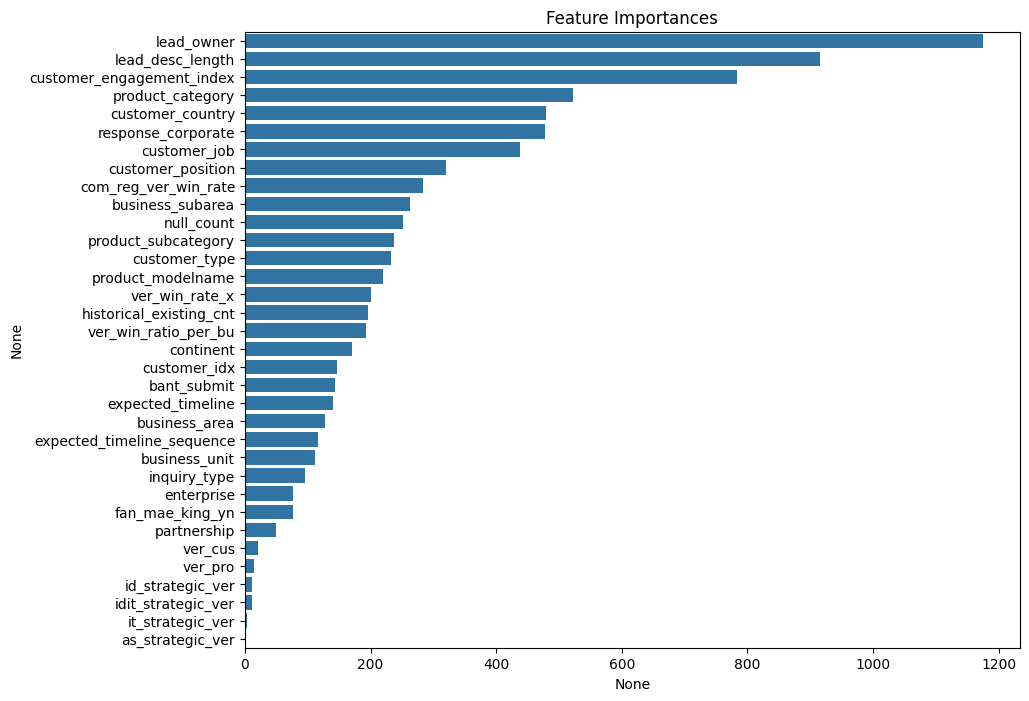

In [355]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [356]:
y_pred_proba = best_model.predict_proba(X_val)[:, 1]

In [357]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

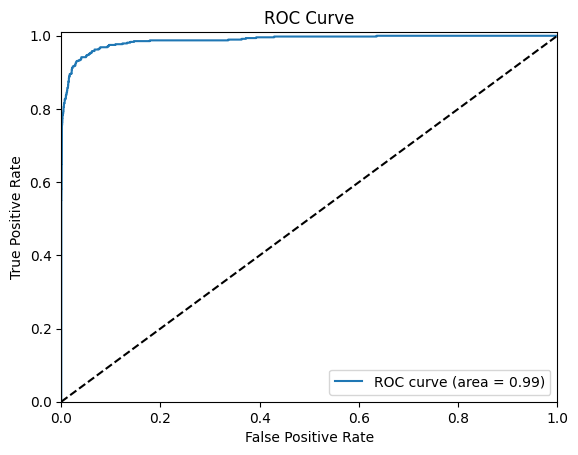

In [358]:
# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [359]:
# 적정 임계값 찾기
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold:", optimal_threshold)

Optimal threshold: 0.08073674671802808


In [360]:
y_pred_custom_threshold = (y_pred_proba >= optimal_threshold).astype(int)

In [361]:
### 기본 쓰레스홀드
pred = best_model.predict(X_val)
get_clf_eval(y_val, pred)

오차행렬:
 [[ 386   93]
 [  25 5139]]

정확도: 0.9791
정밀도: 0.9392
재현율: 0.8058
F1: 0.8674


In [362]:
### 최적 쓰레스홀드
get_clf_eval(y_val, y_pred_custom_threshold)

오차행렬:
 [[ 451   28]
 [ 209 4955]]

정확도: 0.9580
정밀도: 0.6833
재현율: 0.9415
F1: 0.7919


# make submit data

In [363]:
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"], axis=1)

In [364]:
lgbm_params = best_params

In [365]:
# best_params = study.best_params
best_model = LGBMClassifier(
#                            **best_params,
                           **lgbm_params,
                           random_state=1996)

test_pred = best_model.fit(X,y).predict(x_test)
sum(test_pred) # True로 예측된 개수

[LightGBM] [Info] Number of positive: 4680, number of negative: 51748
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1854
[LightGBM] [Info] Number of data points in the train set: 56428, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082938 -> initscore=-2.403088
[LightGBM] [Info] Start training from score -2.403088


588

In [383]:
y_pred_proba = best_model.predict_proba(x_test)[:, 1]  # 양성 클래스에 대한 확률
y_pred_custom_threshold = (y_pred_proba >= optimal_threshold).astype(int)

In [384]:
sum(y_pred_custom_threshold)

1626

In [385]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = y_pred_custom_threshold

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)